# Purpose
The purpose of this notebook is to apply the KVP emulator to the bound state problem with a square well interaction.

# Notebook Setup

## Library import
We import all the required Python libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload    
%autoreload 2

## Local library import
We import all the required local libraries.

In [2]:
from mesh import BuildMesh
from emulator_bound import KVP_emulator_bound
from square_well import SquareWell

## Parameters

In [3]:
### Square well parameters ###
V0 = 3.5
R = 1

### MESH INPUT PARAMETERS ###
ki = 0
cut_reg1 = R - 0.01 # Mesh cutoff of first region
cut_reg2 = R + 0.01 # Mesh cutoff of second region
kf = 4

pts_reg1 = 30 # Total points in first region
pts_reg2 = 60 # Total points in second region
pts_reg3 = 30 # Total points in third region
Ntot = pts_reg1 + pts_reg2 + pts_reg3

In [4]:
mesh_nodes = [ki, cut_reg1, cut_reg2, kf]
pts_per_region = [pts_reg1, pts_reg2, pts_reg3]
mesh = BuildMesh(mesh_nodes, pts_per_region, inf_map=False)
ps, ws = mesh.nodes, mesh.weights

## Calculate exact quantities
This calculates all the exact quantities we are trying to predict for comparison.

In [5]:
sw_exact = SquareWell(V0)
V_exact = sw_exact.Vr(ps)
psi_exact = sw_exact.wf_tot(ps, ws)

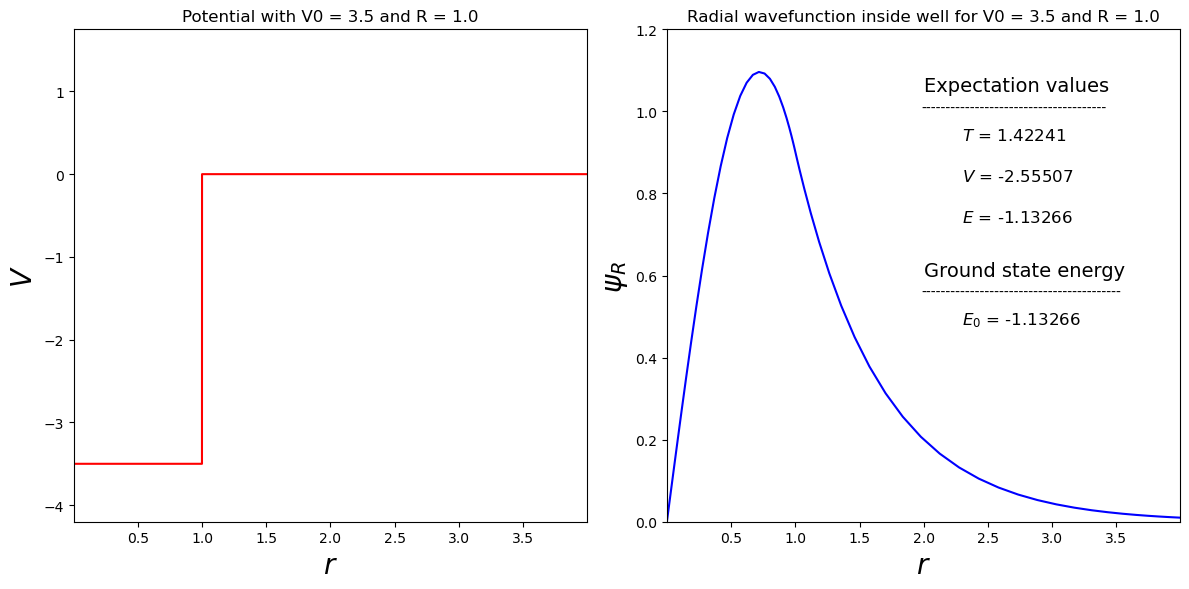

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.plot(ps, V_exact, color='red')
ax1.set_xlim(ps[0], ps[-1])
ax1.set_ylim(-1.2 * sw_exact.V0, 0.5 * sw_exact.V0)
ax1.set_title(fr'Potential with V0 = {V0:.1f} and R = 1.0')
ax1.set_xlabel(r'$r$', fontsize=20)
ax1.set_ylabel(r'$V$', fontsize=20)

ax2.plot(ps, psi_exact, color='blue')
ax2.text(2, 1.05, 'Expectation values', fontsize=14)
ax2.text(1.98, 1.00, '--------------------------------------')
ax2.text(2.3, 0.93, fr'$T$ = {sw_exact.T_ev:.5f}', fontsize=12)
ax2.text(2.3, 0.83, fr'$V$ = {sw_exact.V_ev:.5f}', fontsize=12)
ax2.text(2.3, 0.73, fr'$E$ = {sw_exact.E_ev:.5f}', fontsize=12)
ax2.text(2, 0.60, 'Ground state energy', fontsize=14)
ax2.text(1.98, 0.55, '-----------------------------------------')
ax2.text(2.3, 0.48, fr'$E_0$ = {sw_exact.E_gs():.5f}', fontsize=12)
ax2.set_xlim(ps[0], ps[-1])
ax2.set_ylim(0, 1.2)
ax2.set_title(fr'Radial wavefunction inside well for V0 = {V0:.1f} and R = 1.0')
ax2.set_xlabel(r'$r$', fontsize=20)
ax2.set_ylabel(r'$\psi_R$', fontsize=20)

fig.tight_layout()

## Calculate basis quantities
This calculates all the quantities that will be used for the basis.

In [7]:
V0_b = np.array([30.0, 20.0, 15.0, 10.0, 5.0])

psi_b = np.zeros((V0_b.shape[0], len(ps)))
V_b = np.zeros((V0_b.shape[0], len(ps)))
E_b = np.zeros((V0_b.shape[0]))
T_b = np.zeros((V0_b.shape[0], 2))

for i, V0_i in enumerate(V0_b):
    sw_b = SquareWell(V0_i)
    V_b[i] = sw_b.Vr(ps)
    psi_b[i] = sw_b.wf_tot(ps, ws)
    E_b[i] = sw_b.E_gs()
    T_b[i] = sw_b.kinetic()

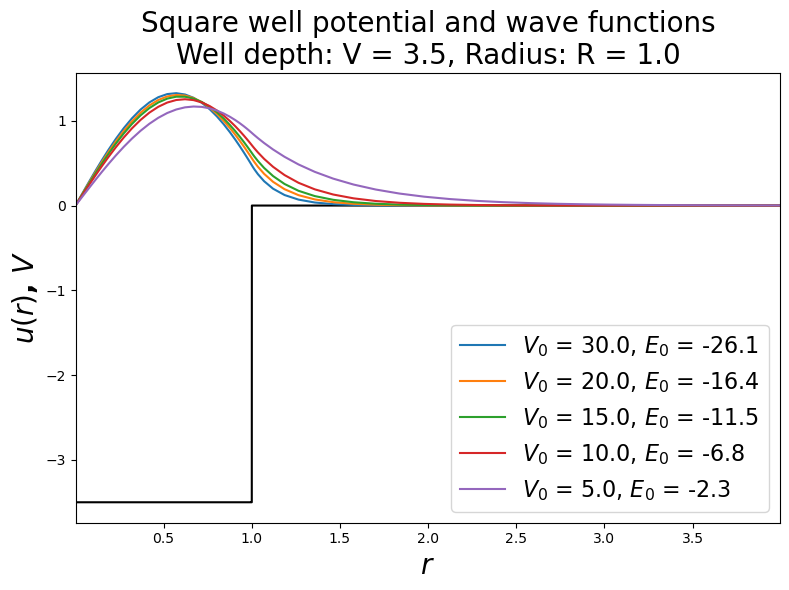

In [8]:
### This cell plots the potential and the wavefunctions for varying V0. ###

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()

ax.plot(ps, V_exact, color='black')

for V0_i, E0_i, wf_i in zip(V0_b, E_b, psi_b):
    ax.plot(ps, wf_i, label=f'$V_0$ = {V0_i:1.1f}, $E_0$ = {E0_i:1.1f}')
    
ax.set_xlim(ps[0], ps[-1])
# ax.set_ylim(-1.1, 1.4)
ax.set_title(fr'Square well potential and wave functions' 
             + '\n' + fr'Well depth: V = {V0:.1f}, ' 
             + fr'Radius: R = 1.0', fontsize=20)
ax.set_xlabel(r'$r$', fontsize=20, fontweight='bold')
ax.set_ylabel(r'$u(r)$, $V$', fontsize=20, fontweight='bold')
ax.legend(loc='lower right', fontsize=16)

fig.tight_layout()


# Implementation

In [9]:
V0_pred = np.arange(2, 31)

abs_error = np.zeros((V0_b.shape[0], V0_pred.shape[0]))
rel_error = np.zeros((V0_b.shape[0], V0_pred.shape[0]))
E_calc = np.zeros((V0_b.shape[0], V0_pred.shape[0]))
E_var = np.zeros((V0_b.shape[0], V0_pred.shape[0]))

for i, V0_i in enumerate(V0_pred):
    for j in range(len(V0_b)):
        sw_b = SquareWell(V0_i)
        E0 = sw_b.E_gs()
    
        emu = KVP_emulator_bound(ps, ws, sw_b.Vr(ps))
        E_pred = emu.energy_pred(psi_b[0:j + 1], T_b[0:j + 1])
        
        E_calc[j, i] = E0
        E_var[j, i] = E_pred
        abs_error[j, i] = abs(E0 - E_pred)
        rel_error[j, i] = abs((E0 - E_pred) / E0)

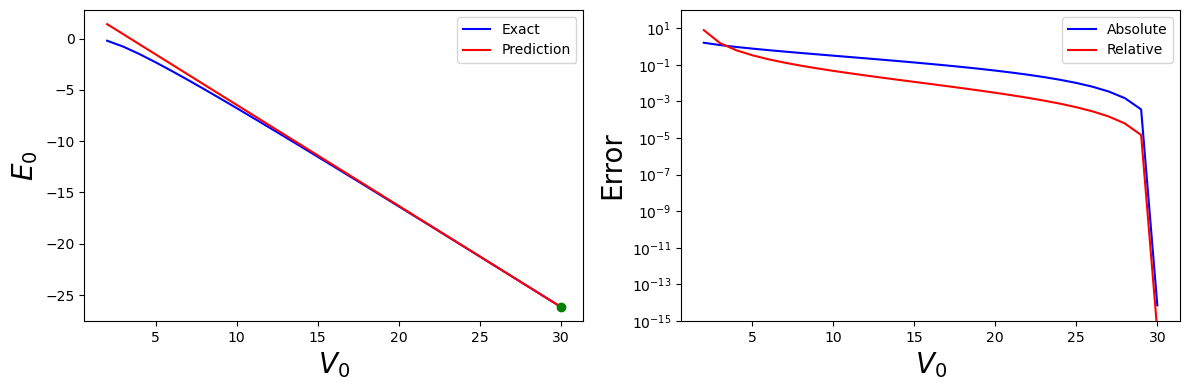

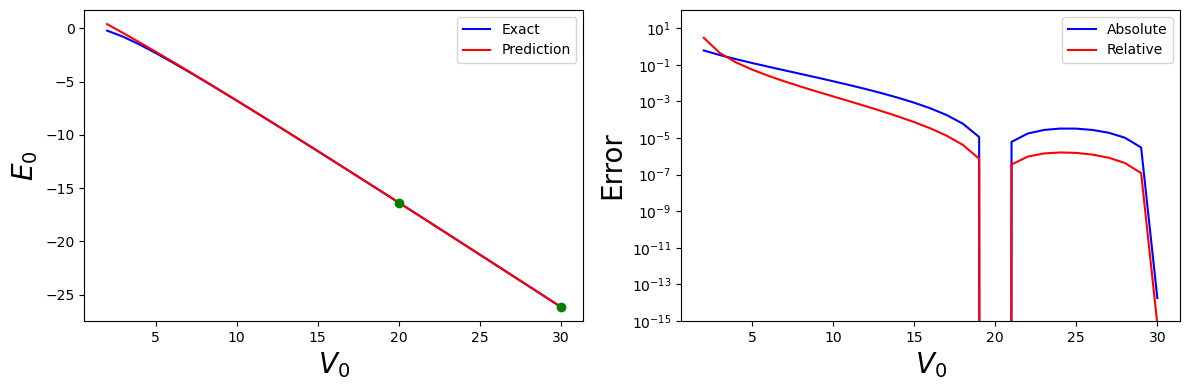

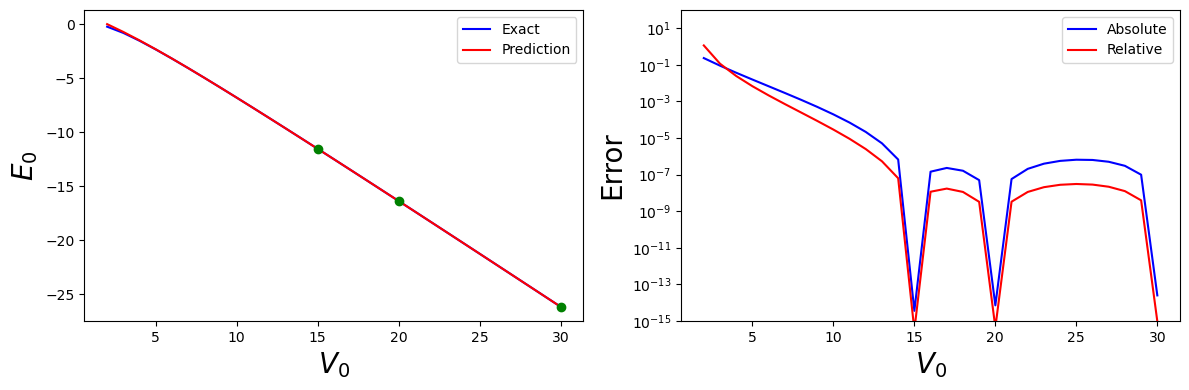

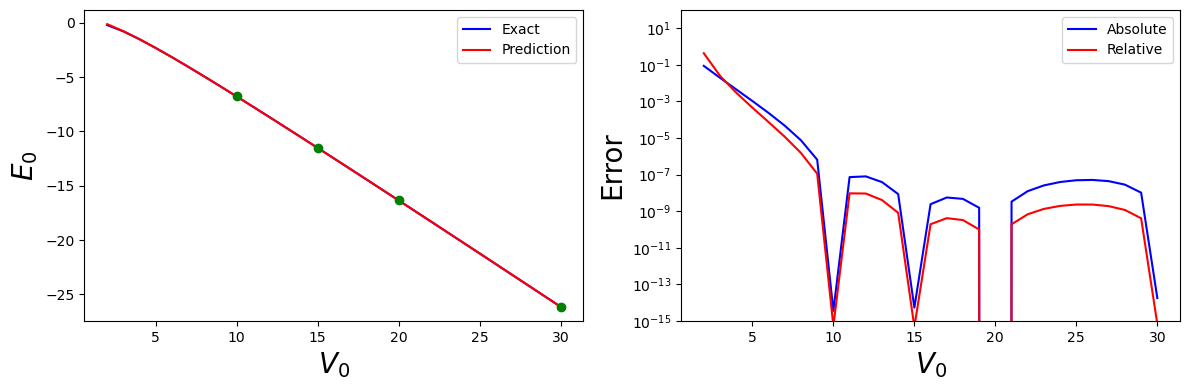

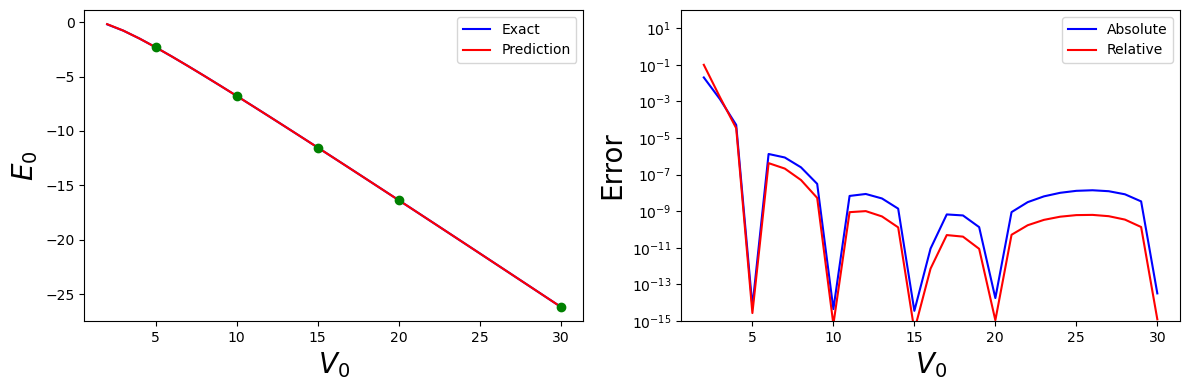

In [10]:
### This cell plots the predicted energy vs the actual energy, ###
### as well as the absolute and relative errors. ###

for i, V0_i in enumerate(V0_b):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(V0_pred, E_calc[i], color='blue', label=f'Exact')
    ax1.plot(V0_pred, E_var[i], color='red', label=f'Prediction')

    for j in range(0, i + 1):
        ax1.plot(V0_b[j], E_b[j], marker='o', color='green')

    ax1.set_xlabel(r'$V_0$', fontsize=20)
    ax1.set_ylabel(r'$E_0$', fontsize=20)
    ax1.legend(loc='upper right')

    ax2.semilogy(V0_pred, abs_error[i], color='blue', label=f'Absolute')
    ax2.semilogy(V0_pred, rel_error[i], color='red', label=f'Relative')
    ax2.set_ylim(1e-15, 1e2)
    ax2.set_xlabel(r'$V_0$', fontsize=20)
    ax2.set_ylabel(r'Error', fontsize=20)
    ax2.legend(loc='upper right')

    fig.tight_layout()